# Lending Club<br />2018 Loan Data<br />Statistical Analysis

The purpose of this project is to apply inferential statistics on 2018 loan data collected on LendingClub website to answer to the following questions:
 - __What is the return on investment (ROI)?__
 - __What is the loss?__
 - __How many months the borrowers are on the loan?__
 - __What is the expected number of defaults for a given sample?__

The data used for this project is a pickle file produced by the data wrangling program. The python notebook for data wrangling program can be found [here](https://github.com/nphan20181/Loan-Default-Prediction/blob/master/loan_data_wrangling.ipynb).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
from scipy import stats
import modules.global_plot_functions as gp   # load user-defined plot functions

pd.set_option('display.max_columns', 150)
sns.set()

In [2]:
# load and prepare data
df = pd.read_pickle('out/2018_LC_Loans_Cleaned.pkl')                 # load cleaned loan data

# roi = total loan payment - loan amount
df['roi'] = df['total_pymnt'] - df['loan_amnt']                      

fully_paids = df[df['loan_status_flag'] == 'Fully Paid'][['roi']]    # fully paid loans
defaults = df[df['loan_status_flag'] == 'Default'][['roi']]          # default loans

# months in loan = issue date - last payment date
df['issue_d'] = pd.to_datetime(df['issue_d'])                        # issue date
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])              # last payment date
df['months_in_loan'] = round((df['last_pymnt_d'] - df['issue_d']) / np.timedelta64(1,'M'), 1)

# loan term
df['term'] = df['term'].apply(lambda x: str.strip(x))                # remove leading and trailing spaces
term_36 = df[df['term'] == '36 months'][['roi', 'months_in_loan', 'loan_status_flag']]
term_60 = df[df['term'] == '60 months'][['roi', 'months_in_loan', 'loan_status_flag']]

In [3]:
def compute_ci(df_in, alpha=0.05):
    '''Compute confidence interval'''
    
    zscore = stats.norm.ppf(alpha/2)
    se = zscore * np.std(df_in, ddof=1) / np.sqrt(len(df_in))   # standard error
    mu = np.mean(df_in)

    # compute 95% Confidence Interval of the mean
    lower = round(mu + se, 2)             # lower bound
    upper = round(mu - se, 2)             # lower bound
    
    return (lower, upper)

In [4]:
def plot_dist(df_in, df_in1=None, label_h=0, label_offset=0, xlabel='', title='2018 LC Loan Data', 
              bins=30, figsize=(10, 6), mu_label='$\mu$\n', mu_label1='', legend=['','']):
    
    fig, ax = plt.subplots(figsize=figsize)
    mu = round(df_in.mean())
    std = round(df_in.std())
    _ = sns.distplot(df_in, bins=bins, color='b', label=legend[0])                  # plot distribution
    
    
    if df_in1 is not None:
        mu1 = round(df_in1.mean())
        std1 = round(df_in1.std())
        _ = sns.distplot(df_in1, bins=bins, color='r', label=legend[1])             # plot distribution
        if mu != mu1:
            ax.axvline(mu1, linestyle='--', color='r')                              # mean vertical line
            plt.text(mu1-label_offset, label_h, mu_label1 + str(mu1), color='r')
        else:
            mu_label = '$\mu$\n'
    
    # mean vertical line
    ax.axvline(mu, linestyle='--', color='b')
    plt.text(mu-label_offset, label_h, mu_label + str(mu), color='b')

    legend = ax.legend(loc='best', frameon=False)
    ax.set_xlabel(xlabel)
    plt.title(title, fontsize=15)
    plt.show()

## Return on Investment

### Default Loans

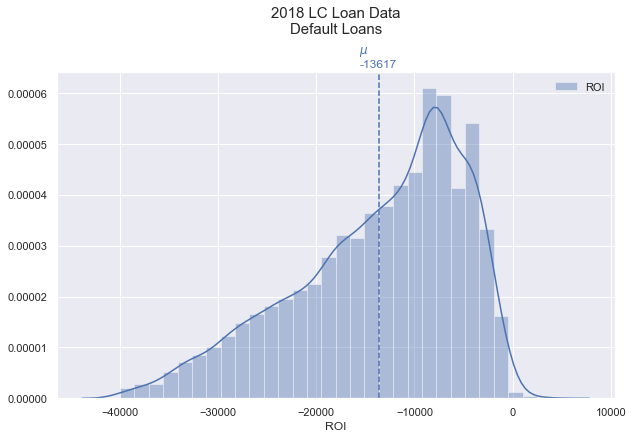

In [5]:
plot_dist(defaults['roi'], label_h=0.000065, label_offset=2000, xlabel='ROI', 
          title='2018 LC Loan Data\nDefault Loans\n\n', legend=['ROI'])

In [6]:
# 95 confidence interval
compute_ci(defaults['roi'])

(-13743.71, -13489.49)

For default loans, we are 95% confident that the average loss is between 13,490 and 13,744 dollars, regardless of loan term.

#### Term: 36 vs. 60 Months

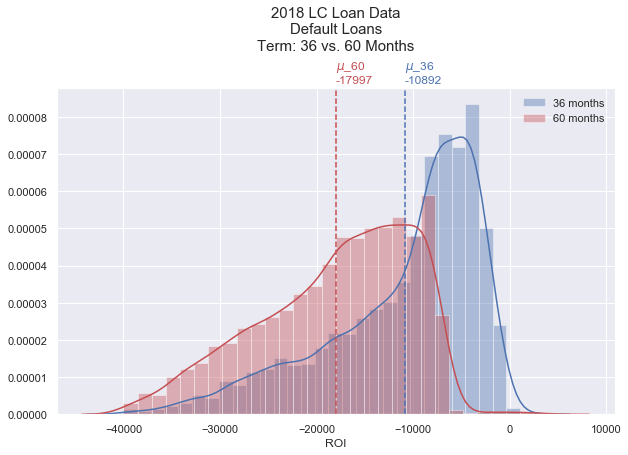

In [7]:
plot_dist(term_36[term_36['loan_status_flag'] == 'Default']['roi'], 
          term_60[term_60['loan_status_flag'] == 'Default']['roi'],
          label_h=0.000089, xlabel='ROI', 
          title='2018 LC Loan Data\nDefault Loans\nTerm: 36 vs. 60 Months\n\n',
          mu_label='$\mu$_36\n', mu_label1='$\mu$_60\n', legend=['36 months', '60 months'])

In [8]:
# 95% ci for 36 months loan
compute_ci(term_36[term_36['loan_status_flag'] == 'Default']['roi'])

(-11040.07, -10743.26)

In [9]:
# 95% ci for 60 months loan
compute_ci(term_60[term_60['loan_status_flag'] == 'Default']['roi'])

(-18185.16, -17809.83)

For default loans, we are 95% confidence that the average loss is between:
- 10,744 and 11,040 dollars for 36 months loan
- 17,810 and 18,185 dollars for 60 months loan

#### Is there a difference in mean of ROI between 36 vs. 60 months loan?

In [10]:
t_test, p_value = stats.ttest_ind(term_36[term_36['loan_status_flag'] == 'Default']['roi'], 
                                 term_60[term_60['loan_status_flag'] == 'Default']['roi'])
t_test, p_value

(58.17481515222897, 0.0)

### Fully Paid Loans

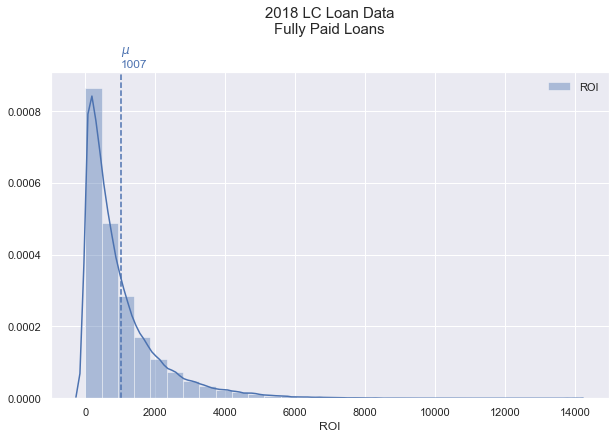

In [11]:
plot_dist(fully_paids['roi'], label_h=0.00092, xlabel='ROI', 
          title='2018 LC Loan Data\nFully Paid Loans\n\n', legend=['ROI'])

In [12]:
compute_ci(fully_paids['roi'])

(998.52, 1014.49)

For fully paid loans, we are 95% confident that the average ROI is between 990 and 1015 dollars, regardless of loan term.

#### Term: 36 vs. 60 Months

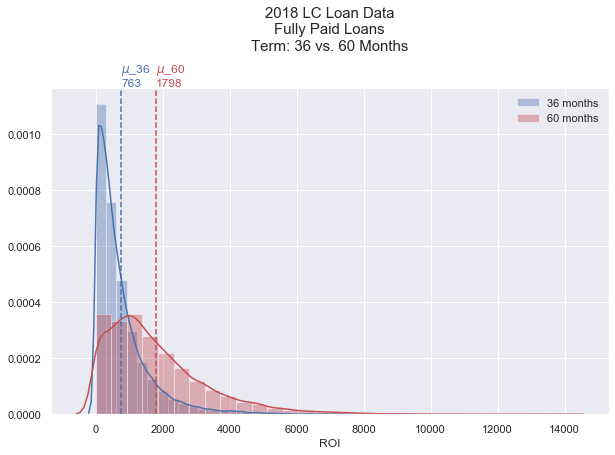

In [13]:
plot_dist(term_36[term_36['loan_status_flag'] == 'Fully Paid']['roi'], 
          term_60[term_60['loan_status_flag'] == 'Fully Paid']['roi'],
          label_h=0.00117, xlabel='ROI', 
          title='2018 LC Loan Data\nFully Paid Loans\nTerm: 36 vs. 60 Months\n\n',
          mu_label='$\mu$_36\n', mu_label1='$\mu$_60\n', legend=['36 months', '60 months'])

In [14]:
# 95% ci for 36 months loan
compute_ci(term_36[term_36['loan_status_flag'] == 'Fully Paid']['roi'])

(756.46, 770.06)

In [15]:
# 95% ci for 60 months loan
compute_ci(term_60[term_60['loan_status_flag'] == 'Fully Paid']['roi'])

(1775.78, 1819.97)

For fully paid loans, we are 95% confident that the ROI is between:
 - 756 and 770 dollars for 36 months loan
 - 1776 and 1820 dollars for 60 months loan

#### Is there a difference in mean of ROI between 36 vs. 60 months loan?

In [16]:
t_test, p_value = stats.ttest_ind(term_36[term_36['loan_status_flag'] == 'Fully Paid']['roi'], 
                                 term_60[term_60['loan_status_flag'] == 'Fully Paid']['roi'])
t_test, p_value

(-116.96944858105742, 0.0)

## Months in Loan

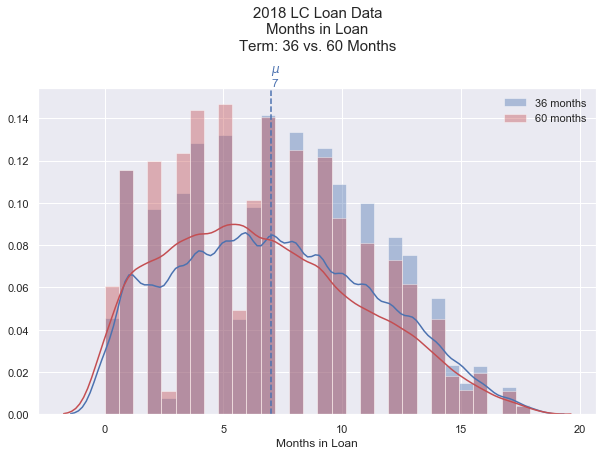

In [17]:
plot_dist(term_36['months_in_loan'], 
          term_60['months_in_loan'],
          label_h=0.155, xlabel='Months in Loan', 
          title='2018 LC Loan Data\nMonths in Loan\nTerm: 36 vs. 60 Months\n\n',
          mu_label='$\mu$_36\n', mu_label1='$\mu$_60\n', legend=['36 months', '60 months'])

The borrowers tend to pay off or default on their loans early. Most borrowers stay on the loan for an average of 7 months.

## Investment Portfolio: Expected Loss of Investment

In [18]:
p_default = len(defaults) / len(df)      # probability of a default loan
no_loans = range(50, 1001, 50)

# amount to be invested in each loan
try:
    amt_inv = float(input('Amount to be invested in each loan: '))
except:
    amt_inv = 50

# build investment portfolio
portfolio = {'no_loans': [],               # number of selected loans
            'expected_no_defaults': [],    # expected number of defaults
            'tot_inv': [],                 # total amount of investment
            'expected_loss': [] }          # total expected loss

# compute expected loss with binomial distribution
for n in no_loans:
    mu = np.round(stats.binom.stats(n, p_default)[0])         # expected number of defaults
    portfolio['no_loans'].append(n)                           # number of selected loans
    portfolio['expected_no_defaults'].append(mu)              # number of defaults to be expected
    portfolio['tot_inv'].append(amt_inv * n)                  # total investnment
    portfolio['expected_loss'].append(amt_inv*mu)             # total expected loss

port_df = pd.DataFrame(portfolio)
port_df

Amount to be invested in each loan: 250


,no_loans,expected_no_defaults,tot_inv,expected_loss
0,50,9.0,12500.0,2250.0
1,100,19.0,25000.0,4750.0
2,150,28.0,37500.0,7000.0
3,200,37.0,50000.0,9250.0
4,250,47.0,62500.0,11750.0
5,300,56.0,75000.0,14000.0
6,350,66.0,87500.0,16500.0
7,400,75.0,100000.0,18750.0
8,450,84.0,112500.0,21000.0
9,500,94.0,125000.0,23500.0
